In [24]:
from src.models import Exponential_Model
from src.criterion import right_censored,RightCensorWrapper,RankingWrapper,RHS_Ranking_Wrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train_robust,lower_bound
from src.visualizations import visualize_population_curves_attacked,visualize_individual_curves_attacked,visualize_individual_curves_changes
from src.metrics import concordance

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

from auto_LiRPA import BoundedModule, BoundedTensor

from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy

from auto_LiRPA import BoundedModule, BoundedTensor
from auto_LiRPA.perturbations import *
from auto_LiRPA.utils import MultiAverageMeter
from auto_LiRPA.eps_scheduler import LinearScheduler, AdaptiveScheduler, SmoothedScheduler, FixedScheduler

In [2]:
# # Define perturbation. Here we add Linf perturbation to input data.
# ptb = PerturbationLpNorm(norm=np.inf, eps=0.1)
# # Make the input a BoundedTensor with the pre-defined perturbation.
# my_input = BoundedTensor(Xb, ptb)
# # # Regular forward propagation using BoundedTensor works as usual.
# # prediction = model(my_input)
# # Compute LiRPA bounds using the backward mode bound propagation (CROWN).
# lb, ub = model.compute_bounds(x=(my_input,Tb,Eb), method="backward",IBP=True)
# ub

In [3]:
class ARGS(object):
    def __init__(self):
        pass

In [4]:
args = ARGS()
args.verify=False
args.device="cpu"

args.seed = 123

args.eps=0.5
args.norm=np.inf
args.bound_type = "CROWN-IBP"
args.num_epochs=150
args.lr = 1e-3
args.batch_size= 32
args.scheduler_name = "SmoothedScheduler"
args.scheduler_opts = "start=100,length=10"
args.hidden_dims = [50,50]
args.pareto = [0.1,.9]
args.save_model = ""
args.dataset = "TRACE"


In [5]:
# GOOD DATASETS
# 1. TRACE
# 2. divorce 
# 3. Dialysis
# 3. Aids2
# 5. Framingham
# 6. rott2
# 7. dataDIVAT1
# 8. prostate
dataset_train,dataset_test = load_datasets(args.dataset,test_size=0.2)

In [6]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1

In [7]:
dataloader_train = DataLoader(dataset_train,batch_size=args.batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=args.batch_size,shuffle=False)

dataloader_train.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_test.std = dataset_train.std


dataset_train.tensors[0].shape

torch.Size([1502, 10])

In [8]:
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile.load_state_dict(deepcopy(clf_robust.state_dict()))


# # model = BoundedModule(clf, X_train)
model_robust_wrap = BoundedModule(RHS_Ranking_Wrapper(clf_robust),dataloader_train.dataset.tensors)
model_fragile_wrap = BoundedModule(RHS_Ranking_Wrapper(clf_fragile),dataloader_train.dataset.tensors)

In [9]:
train_robust(model_robust_wrap,dataloader_train,dataloader_test,method="robust",args=args)

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=163.1323 Time=0.0105
[ 1:  10]: eps=0.00000000 Loss=136.6971 Time=0.0039
[ 1:  20]: eps=0.00000000 Loss=124.3785 Time=0.0035
[ 1:  30]: eps=0.00000000 Loss=112.8741 Time=0.0035
[ 1:  40]: eps=0.00000000 Loss=103.8700 Time=0.0034
[ 1:  46]: eps=0.00000000 Loss=98.9679 Time=0.0034
Epoch time: 0.1718, Total time: 0.1718
Evaluating...
[ 1:  11]: eps=0.00000000 Loss=64.4729 Time=0.0021
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=66.2342 Time=0.0030
[ 2:  10]: eps=0.00000000 Loss=60.4571 Time=0.0033
[ 2:  20]: eps=0.00000000 Loss=60.0675 Time=0.0033
[ 2:  30]: eps=0.00000000 Loss=60.0799 Time=0.0033
[ 2:  40]: eps=0.00000000 Loss=59.0570 Time=0.0033
[ 2:  46]: eps=0.00000000 Loss=58.9201 Time=0.0032
Epoch time: 0.1607, Total time: 0.3325
Evaluating...
[ 2:  11]: eps=0.00000000 Loss=57.8943 Time=0.0027
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=52.1917 Time=0.0036
[ 3:  10]: eps=0.00000000 Loss=

In [10]:
train_robust(model_fragile_wrap,dataloader_train,dataloader_test,method="natural",args=args)

Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=163.1323 Time=0.0188
[ 1:  10]: eps=0.00000000 Loss=136.6971 Time=0.0080
[ 1:  20]: eps=0.00000000 Loss=124.3785 Time=0.0074
[ 1:  30]: eps=0.00000000 Loss=112.8741 Time=0.0064
[ 1:  40]: eps=0.00000000 Loss=103.8700 Time=0.0060
[ 1:  46]: eps=0.00000000 Loss=98.9679 Time=0.0057
Epoch time: 0.2853, Total time: 0.2853
Evaluating...
[ 1:  11]: eps=0.00000000 Loss=64.4729 Time=0.0037
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=66.2342 Time=0.0059
[ 2:  10]: eps=0.00000000 Loss=60.4571 Time=0.0046
[ 2:  20]: eps=0.00000000 Loss=60.0675 Time=0.0049
[ 2:  30]: eps=0.00000000 Loss=60.0799 Time=0.0046
[ 2:  40]: eps=0.00000000 Loss=59.0570 Time=0.0046
[ 2:  46]: eps=0.00000000 Loss=58.9201 Time=0.0048
Epoch time: 0.2333, Total time: 0.5187
Evaluating...
[ 2:  11]: eps=0.00000000 Loss=57.8943 Time=0.0027
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=52.1917 Time=0.0045
[ 3:  10]: eps=0.00000000 Loss=

In [11]:
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)


In [12]:
from lifelines import KaplanMeierFitter,CoxPHFitter,ExponentialFitter
from lifelines.utils import concordance_index

In [13]:
clf_exp = ExponentialFitter()
clf_exp.fit(durations=T_train.ravel(),event_observed=E_train.ravel())

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 1502 total observations, 736 right-censored observations>

<>:20: DeprecationWarning: invalid escape sequence '\l'
C:\Users\lpott\AppData\Local\Temp\ipykernel_28092\671205530.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend(["Kaplan Meier Numerical",f"Exponential Fit $\lambda$={np.round(1/clf_exp.params_[0],4)}","Neural Network Normal","Neural Network Robust"])


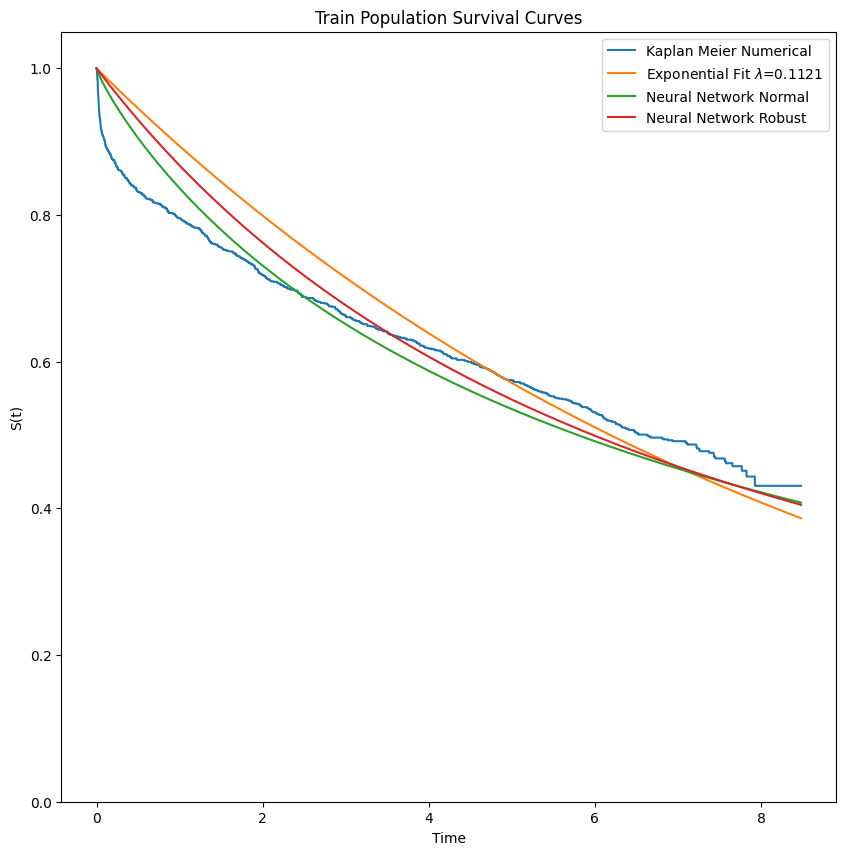

In [14]:
St_robust_x = clf_robust.survival_qdf(X_train,t).detach()
St_fragile_x = clf_fragile.survival_qdf(X_train,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf  = kmf.predict(times=t.ravel().numpy())

clf_exp = ExponentialFitter()
clf_exp.fit(durations=T_train.ravel(),event_observed=E_train.ravel())
St_exp = clf_exp.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_exp)
plt.plot(t,St_fragile_x.mean(0))

plt.plot(t,St_robust_x.mean(0))

plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical",f"Exponential Fit $\lambda$={np.round(1/clf_exp.params_[0],4)}","Neural Network Normal","Neural Network Robust"])
plt.title("Train Population Survival Curves")
plt.ylim([0,1.05])
plt.show()

ROBUST CLF
CI @ eps=10 0.337086004780151
CI @ eps=5 0.35642475055958117
CI @ eps=2 0.5088774232709891
CI @ eps=1 0.6966501005349217
CI @ eps=0.8 0.7203801358169885
CI @ eps=0.7 0.7259949163473577
CI @ eps=0.6 0.7298076558291285
CI @ eps=0.5 0.7298835312417011
CI @ eps=0.1 0.7262794491445047
CI @ eps=0.07 0.7260897606130733
CI @ eps=0.05 0.7258052278159263
CI @ eps=0 0.7250464736902007
NONROBUST CLF
CI @ eps=10 0
CI @ eps=5 0
CI @ eps=2 0.4025949391099814


C:\Users\lpott\OneDrive\Documents\Northeastern University\Classes\EECE 7398 Verifiable Machine Learning\EECE7398_Final_Project\src\metrics.py:16: RuntimeWarning: All-NaN axis encountered
  ub[ub.isnan()] = (np.nanmax(ub) + torch.tensor(np.random.randn(ub.isnan().sum(), 1)).ravel()).type(


CI @ eps=1 0.5209795515763117
CI @ eps=0.8 0.5630145301415076
CI @ eps=0.7 0.5886793884441747
CI @ eps=0.6 0.620129746955499
CI @ eps=0.5 0.6533821465154217
CI @ eps=0.1 0.7223528965438749
CI @ eps=0.07 0.7216320801244357
CI @ eps=0.05 0.7208733259987101
CI @ eps=0 0.7196593193975492


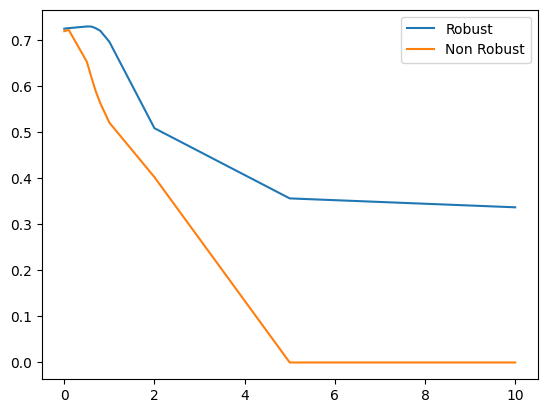

In [15]:
epsilons = [10,5,2,1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("ROBUST CLF")
eps_,ci_ = concordance(clf_robust,dataloader_test,epsilons)
plt.figure()
plt.plot(eps_,ci_)
print("NONROBUST CLF")
eps_,ci_ = concordance(clf_fragile,dataloader_test,epsilons)
plt.plot(eps_,ci_)
plt.legend(["Robust","Non Robust"])

<>:9: DeprecationWarning: invalid escape sequence '\l'


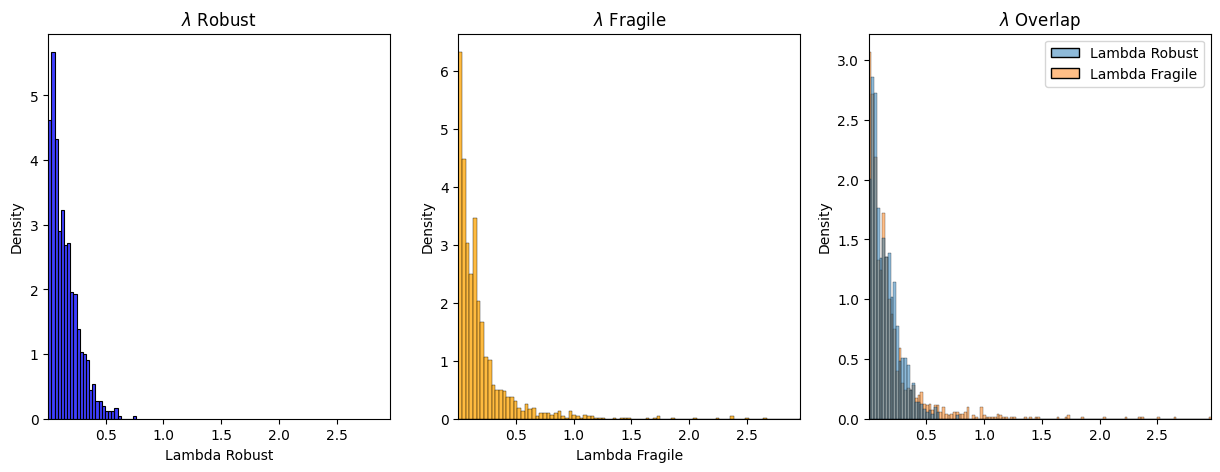

In [101]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
lambda_robust = clf_robust(X_train).detach()
lambda_fragile = clf_fragile(X_train).detach()

plot_df  = pd.DataFrame({"Lambda Robust":lambda_robust.ravel(),"Lambda Fragile":lambda_fragile.ravel()})

sns.histplot(data=plot_df,x="Lambda Robust",ax=axes[0],stat="density",legend=False,color="blue")
axes[0].set_xlim([lambda_fragile.min(),lambda_fragile.quantile(0.99)])
axes[0].set_title("$\lambda$ Robust")

axes[1].set_xlim([lambda_fragile.min(),lambda_fragile.quantile(0.99)])
axes[1].set_title("$\lambda$ Fragile")
sns.histplot(data=plot_df,x="Lambda Fragile",ax=axes[1],stat="density",legend=False,color="orange")

axes[2].set_xlim([lambda_fragile.min(),lambda_fragile.quantile(0.99)])
axes[2].set_title("$\lambda$ Overlap")
sns.histplot(data=plot_df,ax=axes[2],stat="density",legend=True)

plt.show()

<Figure size 1000x1000 with 0 Axes>

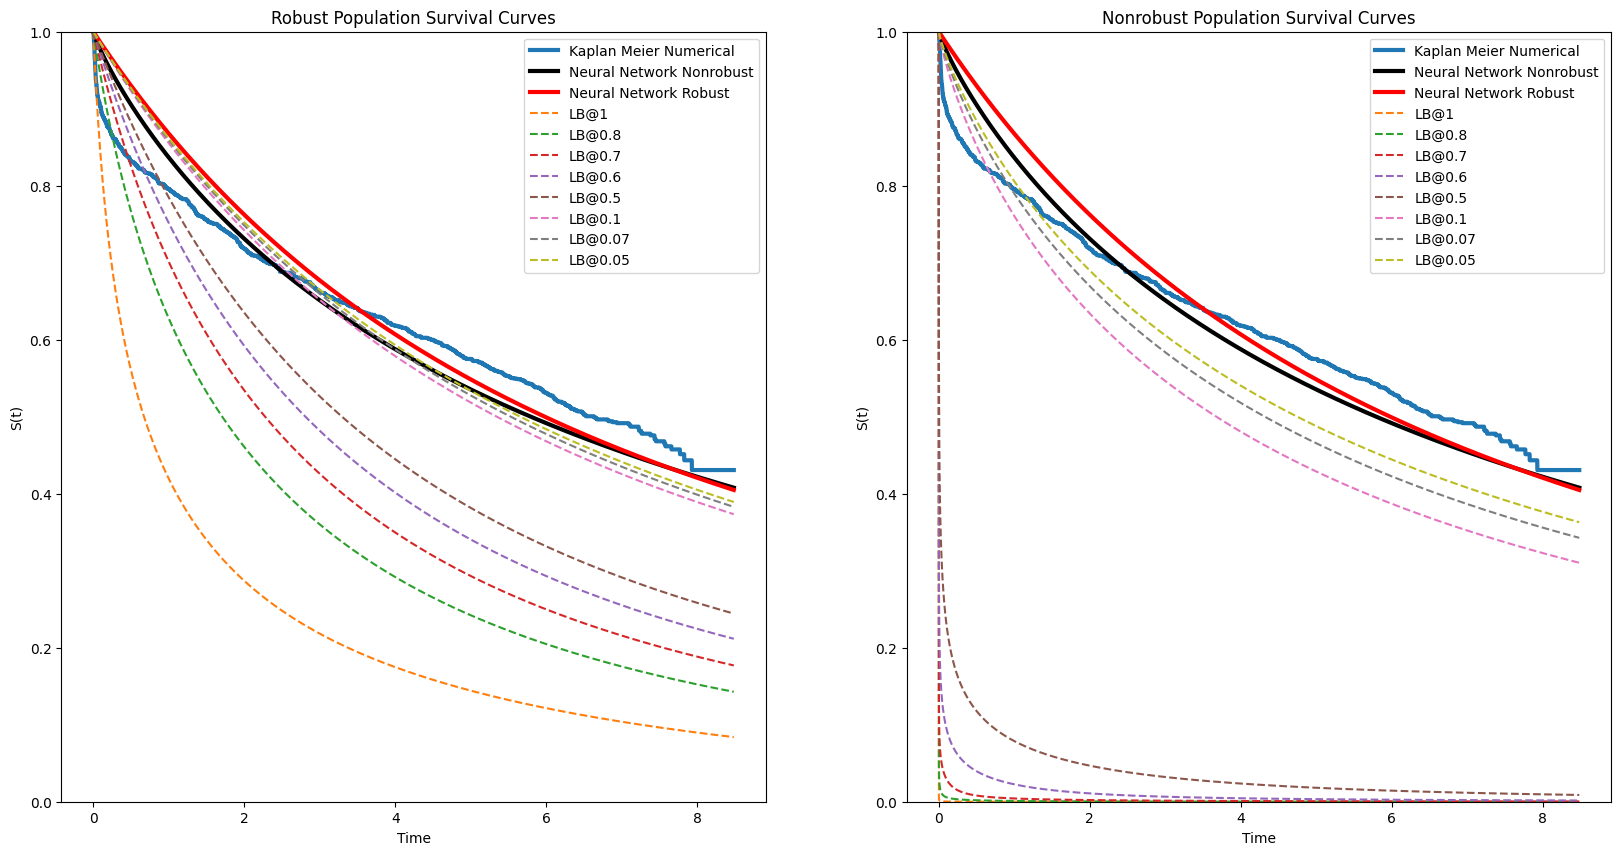

<Figure size 1000x1000 with 0 Axes>

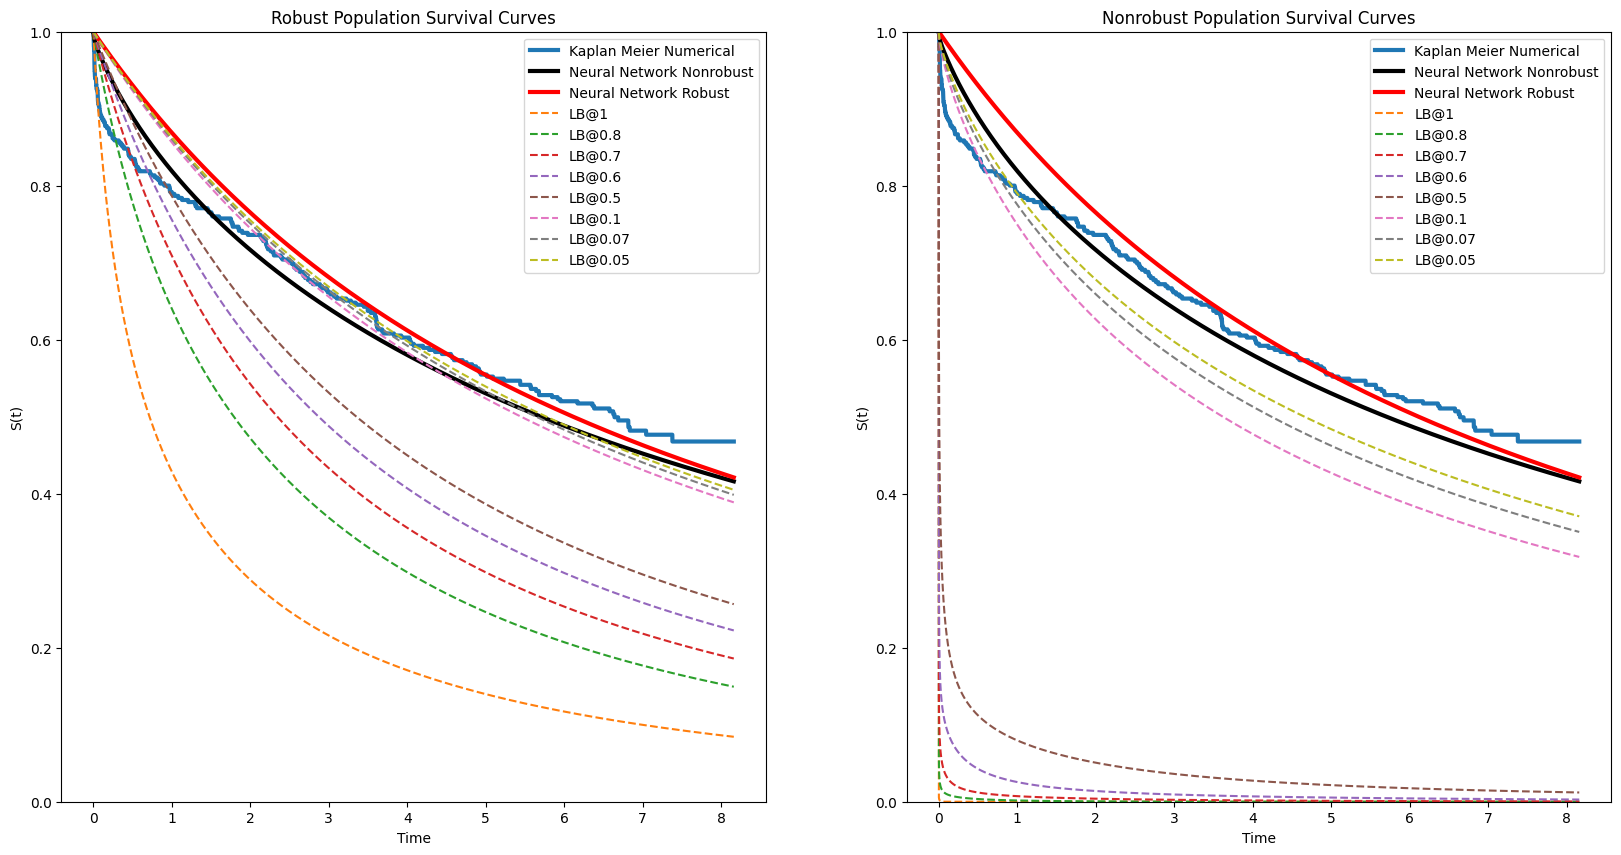

In [26]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_train,epsilons=epsilons)
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_test,epsilons=epsilons)